In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 12}

plt.rc('font', **font)
plot_fs = 12

plt.rc('font', family='serif', serif='Times')
plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=9)
plt.rc('ytick', labelsize=9)
plt.rc('axes', labelsize=10)
mpl.rcParams['lines.dashed_pattern'] = [2, 2]
mpl.rcParams['lines.linewidth'] = 1.0

import sys
print(sys.version)
sys.path.append('../')

from models.powertrain.bounded_powertrain import Bounded_powertrain
from models.kinematic.ideal_diff_drive import Ideal_diff_drive
from models.learning.blr_slip import SlipBayesianLinearRegression, FullBodySlipBayesianLinearRegression
from models.learning.blr_slip_acceleration import SlipAccelerationBayesianLinearRegression, FullBodySlipAccelerationBayesianLinearRegression
from models.kinematic.ICR_based import *
from models.kinematic.Perturbed_unicycle import *
from models.kinematic.enhanced_kinematic import *

from util.transform_algebra import *
from util.util_func import *

3.8.12 (default, Oct 12 2021, 06:23:56) 
[Clang 10.0.0 ]


In [2]:
# import slip dataset

# dataset_path = '../data/ral2023_dataset/husky/boreal_snow/slip_dataset_all.pkl'
# dataset_path = '../data/ral2023_dataset/husky/grand_salon_tile_inflated/slip_dataset_all.pkl'
# dataset_path = '../data/ral2023_dataset/husky/grand_salon_left-deflated/slip_dataset_all.pkl'
# dataset_path = '../data/ral2023_dataset/marmotte/boreal_snow/slip_dataset_all.pkl'
# dataset_path = '../data/ral2023_dataset/marmotte/ga_hard_snow_a/slip_dataset_all.pkl'
# dataset_path = '../data/ral2023_dataset/marmotte/ga_hard_snow_b/slip_dataset_all.pkl'
# dataset_path = '../data/ral2023_dataset/marmotte/grand_salon_tile_b/slip_dataset_all.pkl'
# dataset_path = '../data/ral2023_dataset/warthog_tracks/boreal_mud/slip_dataset_all.pkl'
# dataset_path = '../data/ral2023_dataset/warthog_tracks/grand-axe_crusted-snow/slip_dataset_all.pkl'

# dataset_path = '../data/ral2023_dataset/husky/boreal_snow/acceleration_dataset.pkl'
# dataset_path = '../data/ral2023_dataset/husky/grand_salon_tile_inflated/acceleration_dataset.pkl'
# dataset_path = '../data/ral2023_dataset/husky/grand_salon_left-deflated/acceleration_dataset.pkl'
dataset_path = '../data/ral2023_dataset/marmotte/boreal_snow/acceleration_dataset.pkl'
# dataset_path = '../data/ral2023_dataset/marmotte/ga_hard_snow_a/acceleration_dataset.pkl'
# dataset_path = '../data/ral2023_dataset/marmotte/ga_hard_snow_b/acceleration_dataset.pkl'
# dataset_path = '../data/ral2023_dataset/marmotte/grand_salon_tile_b/acceleration_dataset.pkl'
# dataset_path = '../data/ral2023_dataset/warthog_tracks/boreal_mud/acceleration_dataset.pkl'
# dataset_path = '../data/ral2023_dataset/warthog_tracks/grand-axe_crusted-snow/acceleration_dataset.pkl'
# dataset_path = '../data/ral2023_dataset/warthog_wheels/gravel_1/acceleration_dataset.pkl'

human_dataset = pd.read_csv('../data/ral2023_dataset/warthog_wheels/crv2020/human-commanded_speeds.csv')


full_dataset = pd.read_pickle(dataset_path)
full_dataset_length = len(full_dataset)
train_dataset = full_dataset[:int(full_dataset_length/2)]
validate_dataset = full_dataset[int(full_dataset_length/2):]

print(train_dataset.columns)

Index(['init_icp_x', 'init_icp_y', 'init_icp_z', 'init_icp_roll',
       'init_icp_pitch', 'init_icp_yaw', 'calib_step', 'cmd_left_0',
       'cmd_right_0', 'cmd_left_1',
       ...
       'icp_acceleration_yaw_30', 'icp_acceleration_yaw_31',
       'icp_acceleration_yaw_32', 'icp_acceleration_yaw_33',
       'icp_acceleration_yaw_34', 'icp_acceleration_yaw_35',
       'icp_acceleration_yaw_36', 'icp_acceleration_yaw_37',
       'icp_acceleration_yaw_38', 'icp_acceleration_yaw_39'],
      dtype='object', length=1458)


In [3]:
# extract cmd vels
cmd_left_str_list = []
cmd_right_str_list = []
for i in range(0, 40):
    cmd_left_str_i = 'cmd_left_' + str(i)
    cmd_right_str_i = 'cmd_right_' + str(i)
    cmd_left_str_list.append(cmd_left_str_i)
    cmd_right_str_list.append(cmd_right_str_i)
cmd_left_vels = train_dataset[cmd_left_str_list].to_numpy()
cmd_right_vels = train_dataset[cmd_right_str_list].to_numpy()

# extract encoder vels
wheel_radius = 0.3
baseline = 1.1652
ideal_diff_drive = Ideal_diff_drive(wheel_radius, baseline, dt=0.05)
encoder_left_str_list = []
encoder_right_str_list = []
for i in range(0, 40):
    str_encoder_left_i = 'left_wheel_vel_' + str(i)
    str_encoder_right_i = 'right_wheel_vel_' + str(i)
    encoder_left_str_list.append(str_encoder_left_i)
    encoder_right_str_list.append(str_encoder_right_i)
encoder_left_vels = train_dataset[encoder_left_str_list].to_numpy()
encoder_right_vels = train_dataset[encoder_right_str_list].to_numpy()
encoder_body_vel_x = np.zeros((encoder_left_vels.shape[0], 40))
encoder_body_vel_yaw = np.zeros((encoder_left_vels.shape[0], 40))
for i in range(0, encoder_left_vels.shape[0]):
    for j in range(0, 40):
        body_vel = ideal_diff_drive.compute_body_vel(np.array([encoder_left_vels[i,j], encoder_right_vels[i, j]]))
        encoder_body_vel_x[i,j] = body_vel[0]
        encoder_body_vel_yaw[i,j] = body_vel[1]

# extract icp vels
transitory_left_str_list = []
transitory_right_str_list = []
for i in range(0, 40):
    transitory_left_str_i = 'transitory_vel_left_' + str(i)
    transitory_right_str_i = 'transitory_vel_right_' + str(i)
    transitory_left_str_list.append(transitory_left_str_i)
    transitory_right_str_list.append(transitory_right_str_i)
transitory_left_vels = train_dataset[transitory_left_str_list].to_numpy()
transitory_right_vels = train_dataset[transitory_right_str_list].to_numpy()



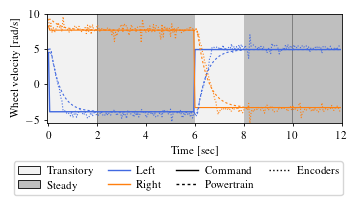

In [123]:
from matplotlib.lines import Line2D
from matplotlib.patches import Patch, Rectangle

plt.rc('font', family='serif', serif='Times')
plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=8)
plt.rc('ytick', labelsize=8)
plt.rc('axes', labelsize=8)
mpl.rcParams['lines.dashed_pattern'] = [2, 2]

width  = 3.402
height = width / 1.8

cmd_linestyle = 'solid'
encoder_linestyle = 'dotted'
transitory_linestyle = 'dashed'
left_wheel_color = 'royalblue'
right_wheel_color = 'C1'

###################################### grey colors
steady_state_alpha = 0.5
transitory_state_alpha= 0.1
alpha_line = 1

steady_state_color = mpl.colors.to_rgba('grey')
steady_state_color_list = list(steady_state_color)
steady_state_color_list[3] = steady_state_alpha
steady_state_color = tuple(steady_state_color_list)

transitory_state_color = mpl.colors.to_rgba('grey')
transitory_state_color_list = list(transitory_state_color)
transitory_state_color_list[3] = transitory_state_alpha
transitory_state_color = tuple(transitory_state_color_list)
###################################### grey colors

window_id = 9

fig, ax = plt.subplots()
fig.set_size_inches(width, height)
fig.subplots_adjust(left=.115, bottom=0.39, right=.98, top=.97)

myWidth = 0.6
plot_line_width = 0.8

for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(myWidth)
    ax.tick_params(direction='out', length=2)

ax.tick_params(width=myWidth)

ymin = -5.5
ymax = 10
thickness = 0.5

ax.fill_between([-1, 40], ymax, ymin, color=transitory_state_color, linewidth=0)
ax.fill_between([40, 80], ymax, ymin, color=steady_state_color, linewidth=0)
ax.add_patch(Rectangle((40-thickness/2, ymin), thickness, -ymin + ymax, facecolor='grey', alpha=alpha_line, linewidth=0))
ax.fill_between([80, 120], ymax, ymin, color=steady_state_color, linewidth=0)
ax.add_patch(Rectangle((80-thickness/2, ymin), thickness, -ymin + ymax, facecolor='grey', alpha=alpha_line, linewidth=0))
ax.fill_between([120, 160], ymax, ymin, color=transitory_state_color, linewidth=0)
ax.add_patch(Rectangle((120-thickness/2, ymin), thickness, -ymin + ymax, facecolor='grey', alpha=alpha_line, linewidth=0))
ax.fill_between([160, 200], ymax, ymin, color=steady_state_color, linewidth=0)
ax.add_patch(Rectangle((160-thickness/2, ymin), thickness, -ymin + ymax, facecolor='grey', alpha=alpha_line, linewidth=0))
ax.fill_between([200, 240], ymax, ymin, color=steady_state_color, linewidth=0)
ax.add_patch(Rectangle((200-thickness/2, ymin), thickness, -ymin + ymax, facecolor='grey', alpha=alpha_line, linewidth=0))

cmd = ax.plot(cmd_left_vels[window_id:window_id+6, :].flatten(), color=left_wheel_color, linestyle=cmd_linestyle, label='cmd')
ax.plot(cmd_right_vels[window_id:window_id+6, :].flatten(), color=right_wheel_color, linestyle=cmd_linestyle, linewidth=plot_line_width)
ax.plot(encoder_left_vels[window_id:window_id+6, :].flatten(), color=left_wheel_color, linestyle=encoder_linestyle, linewidth=plot_line_width)
ax.plot(encoder_right_vels[window_id:window_id+6, :].flatten(), color=right_wheel_color, linestyle=encoder_linestyle,linewidth=plot_line_width)
ax.plot(transitory_left_vels[window_id:window_id+6, :].flatten(), color=left_wheel_color, linestyle=transitory_linestyle, linewidth=plot_line_width)
ax.plot(transitory_right_vels[window_id:window_id+6, :].flatten(), color=right_wheel_color, linestyle=transitory_linestyle, linewidth=plot_line_width)

ax.set_xlabel('Time [sec]')
ax.set_ylabel('Wheel velocity [rad/s]')

ax.set_ylim(ymin, ymax)
ax.set_xlim(-1, 240)

xticks = [0, 40, 80, 120, 160, 200, 240]
xticks_labels = [0, 2, 4, 6, 8, 10, 12]
ax.set_xticks(xticks, xticks_labels)

legend_elements = [Patch(facecolor=transitory_state_color, label='Transitory', linestyle='solid', edgecolor='k', linewidth=myWidth),
                   Patch(facecolor=steady_state_color, label='Steady', linestyle='solid', edgecolor='k', linewidth=myWidth),
                   Line2D((0,2), (1,1), label='Left', color=left_wheel_color),
                   Line2D((0,2), (1,1), label='Right', color=right_wheel_color),
                   Line2D((0,2), (1,1), linestyle=cmd_linestyle, label='Command', color='k'),
                   Line2D((0,2), (1,1), linestyle=transitory_linestyle, label='Powertrain', color='k'),
                   Line2D((0,2), (1,1), linestyle=encoder_linestyle, label='Encoders', color='k')]

fig.legend(handles=legend_elements, loc='center', ncol=4, bbox_to_anchor=(0.5,0.1), prop={'size': 8}, columnspacing=1.4, labelspacing=0.4, handletextpad=0.6,
           handleheight=0.7, handlelength=1.95)

plt.savefig('figs/powertrain_calib_steps_cg_v1.pdf', dpi=500)
plt.savefig('figs/powertrain_calib_steps_cg_v1.jpg', dpi=500)